In [1]:
import os
import pandas as pd
import ROOT as r
from datetime import datetime
import matplotlib.pyplot as plt

Warning in <TInterpreter::ReadRootmapFile>: class  edm::Wrapper<std::vector<bool> > found in libDataFormatsWrappedStdDictionaries.so  is already in libOSUT3AnalysisAnaTools.so 
Warning in <TInterpreter::ReadRootmapFile>: class  edm::Wrapper<vector<bool> > found in libDataFormatsWrappedStdDictionaries.so  is already in libOSUT3AnalysisAnaTools.so 


Welcome to JupyROOT 6.24/07


In [2]:
class lumiDict:
    
    def __init__(self):
        
        self.run = -1
        self.file = -1
        self.lumis = None
        self.fill = None
        self.beam = None
        self.dir = None
        self.filename = None
        self.start = None
        self.stop = None
    

In [47]:
class mqLumiList():
    
    def __init__(self):
        self.lumi_csv = ''
        self.rawPath = '/store/user/milliqan/run3/'
        self.mqLumis = pd.DataFrame(columns=['run', 'file', 'lumis', 'fill', 'beam', 'dir', 'filename', 'start', 'stop'])
        self.debug = False
        
    def looper(self):
        #rawDirectories = ['1000', '1100']
        #rawSubDirectories = ['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009']
        rawDirectories = ['1100']
        rawSubDirectories = ['0009']

        for i, d1 in enumerate(rawDirectories):
            for j, d2 in enumerate(rawSubDirectories):
                if self.debug and j > 0: return
                if not os.path.exists(self.rawPath+'/'+d1+'/'+d2): continue
                self.initializeDataframe('{0}/{1}'.format(d1, d2))
                self.setFileTimes()
                self.setMQLumis()
                if not self.debug: self.saveJson()

                
    def initializeDataframe(self, path):
        fileCnt = 0
        for ifile, filename in enumerate(os.listdir(self.rawPath+'/'+path)):
            if self.debug and fileCnt > 100: 
                return
            if not filename.startswith("MilliQan"): continue
            if fileCnt % 1000 == 0: print("Working on processing file {}".format(fileCnt))
            runNum_, fileNum_ = self.getRunFile(filename)
            #if int(runNum_) != 1006: continue #temp
            #if int(fileNum_) > 190 or int(fileNum_) < 180: continue #temp
            dict_ = lumiDict()
            dict_.run = int(runNum_)
            dict_.file = (fileNum_)
            dict_.dir = self.rawPath+'/'+path
            dict_.filename = filename
            self.mqLumis.loc[len(self.mqLumis.index)] = dict_.__dict__
            fileCnt += 1
                    
                        
    def getRunFile(self, filename):
        runNum = filename.split('Run')[-1].split('.')[0]
        fileNum = filename.split('.')[1].split('_')[0]
        return runNum, fileNum
        
    def openLumis(self):
        self.lumiList = pd.read_csv('Run3Lumis.csv')

    def convertDatetime(self, time):
        dt_ = datetime.strptime(time, '%Y-%m-%d_%Hh%Mm%Ss')
        return dt_   

    def getFileTime(self, file):
        try:
            myfile = r.TFile.Open(file)
        except:
            print("File {} is a zombie, skipping...".format(file))
            return pd.NaT, pd.NaT
        meta = myfile.Get('Metadata')
        t_open = -1
        t_close = -1
        for event in meta:
            t_open = event.fileOpenTime
            t_close = event.fileCloseTime
        d_open = self.convertDatetime(str(t_open))
        d_close = self.convertDatetime(str(t_close))
        return d_open, d_close
        
    def setFileTimes(self):
        self.mqLumis[['start', 'stop']] = self.mqLumis.apply(lambda x: self.getFileTime(x.dir + '/' + x.filename) if pd.isnull(x.start) else (x.start, x.stop), axis='columns', result_type='expand')
        
    def addDatetimes(self):
        self.lumiList['start_time'] = self.lumiList['start_time'].where(pd.notnull(self.lumiList['start_time']), None)
        self.lumiList['end_time'] = self.lumiList['end_time'].where(pd.notnull(self.lumiList['end_time']), None)
        self.lumiList['start_stable_beam'] = self.lumiList['start_stable_beam'].astype(object).where(pd.notnull(self.lumiList['start_stable_beam']), None)

        self.lumiList['end_stable_beam'] = self.lumiList['end_stable_beam'].astype(object).where(pd.notnull(self.lumiList['end_stable_beam']), None)

        self.lumiList['start_time'] = self.lumiList['start_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S') if x != None else x)
        self.lumiList['end_time'] = self.lumiList['end_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S') if x != None else x)
        self.lumiList['start_stable_beam'] = self.lumiList['start_stable_beam'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S') if x != None else x)
        self.lumiList['end_stable_beam'] = self.lumiList['end_stable_beam'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S') if x != None else x)

        self.lumiList = self.lumiList.sort_values(by=['start_time'])
        self.lumiList = self.lumiList.reset_index(drop=True)
        
        self.lumiList['start_stable_beam'].replace({pd.NaT: None}, inplace=True)
        self.lumiList['end_stable_beam'].replace({pd.NaT: None}, inplace=True)


        
    def findLumiStart(self, start, stop):
    
        startId = -1
        stopId = -1

        #special case for zombie files (maybe better way than letting it get this far?)
        if pd.isnull(start) or pd.isnull(stop):
            mqLumi = 0
            lumis = 0
            fillId = None 
            beamType = None 
            beamEnergy = None
            betaStar = None 
            beamOn = False 
            fillStart = None 
            fillEnd = None
            startStableBeam = None
            endStableBeam = None
            return lumis, fillId, beamType, beamEnergy, betaStar, beamOn, fillStart, fillEnd, startStableBeam, endStableBeam, mqLumi
        
        #if milliqan run starts after all runs in lumi list
        if start > self.lumiList.start_time.max():
            mqLumi = 0
            lumis = 0
            fillId = None 
            beamType = None 
            beamEnergy = None
            betaStar = None 
            beamOn = False 
            fillStart = None 
            fillEnd = None
            startStableBeam = None
            endStableBeam = None
            return lumis, fillId, beamType, beamEnergy, betaStar, beamOn, fillStart, fillEnd, startStableBeam, endStableBeam, mqLumi
        
        for i, st in enumerate(self.lumiList.start_time):
            if start < st: 
                startId = i-1
                break
        for i, (st, et) in enumerate(zip(self.lumiList.end_time[startId:], self.lumiList.start_time[startId:])):
            if stop < st: 
                stopId = startId + i
                break
            elif stop < et:
                stopId = startId + i
                break
        
        #if last milliqan run stops after last LHC run
        if stop > self.lumiList.end_time.max():
            stopId = len(self.lumiList)-1
                
        if startId == stopId:
            fillId = self.lumiList['fill_number'][startId]
            beamType = self.lumiList['fill_type_runtime'][startId]
            beamEnergy = self.lumiList['energy'][startId]
            betaStar = self.lumiList['beta_star'][startId]
            fillStart = self.lumiList['start_time'][startId]
            fillEnd = self.lumiList['end_time'][stopId]
            lumis = self.lumiList['delivered_lumi'][startId]
            startStableBeam = self.lumiList['start_stable_beam'][startId]
            endStableBeam = self.lumiList['end_stable_beam'][startId]
            beamOn = False
            if not pd.isna(self.lumiList['start_time'][startId]):
                beamOn = True
            
            mqLumi = 0
            if beamOn:
                totalLumi = self.lumiList['delivered_lumi'][startId]
                totalFillTime = self.lumiList['duration'][startId]
                totalMQTime = (stop-start).total_seconds()
                #print(totalLumi, totalFillTime, totalMQTime)
                frac = totalMQTime / totalFillTime
                mqLumi = totalLumi * frac
                
        else:
            #print("ids", startId, stopId)
            #print("start fill {0}, stop fill {1}".format(self.lumiList['fill_number'][startId], self.lumiList['fill_number'][stopId]))
            fillId = self.lumiList['fill_number'][startId:stopId+1].to_list()
            beamType = self.lumiList['fill_type_runtime'][startId:stopId+1].to_list()
            beamEnergy = self.lumiList['energy'][startId:stopId+1].to_list()
            betaStar = self.lumiList['beta_star'][startId:stopId+1].to_list()
            beamOn = [False if pd.isna(x) else True for x in self.lumiList['start_time'][startId:stopId+1]]
            fillStart = self.lumiList['start_time'][startId:stopId+1].to_list()
            fillEnd = self.lumiList['end_time'][startId:stopId+1].to_list()
            lumis = self.lumiList['delivered_lumi'][startId:stopId+1].to_list()
            startStableBeam = self.lumiList['start_stable_beam'][startId:stopId+1].to_list()
            endStableBeam = self.lumiList['end_stable_beam'][startId:stopId+1].to_list()
            mqLumi = 0
            for i in range(startId, stopId+1):
                x = self.lumiList[['start_time', 'end_time', 'start_stable_beam', 'end_stable_beam', 'delivered_lumi', 'duration', 'fill_number']].iloc[i]
                #print("checking fill", x.fill_number)
                if pd.isna(x.delivered_lumi): continue
                if start > x.end_stable_beam: continue
                if start < x.start_stable_beam: #milliqan run starts before fill
                    if stop >= x.end_stable_beam: #milliqan run spans entire fill
                        mqLumi += x.delivered_lumi
                    elif stop < x.end_stable_beam: #milliqan run stops before end of fill
                        total_time = (stop - x.start_stable_beam).total_seconds()
                        frac = total_time / x.duration
                        mqLumi += frac * x.delivered_lumi
                elif start > x.start_stable_beam: #milliqan run starts after fill
                    if stop >= x.end_stable_beam: #milliqan run ends after fill
                        total_time = (x.end_stable_beam - start).total_seconds()
                        frac = total_time / x.duration
                        mqLumi += frac * x.delivered_lumi
                    elif stop < x.end_stable_beam: #milliqan run ends before fill
                        print("This should be handled already!")
                else:
                    print("Bug in code, this case isn't handled")
                
            
        #print(mqLumi, fillId, beamType, beamEnergy, betaStar, beamOn, fillStart, fillEnd)
        
        return lumis, fillId, beamType, beamEnergy, betaStar, beamOn, fillStart, fillEnd, startStableBeam, endStableBeam, mqLumi
    
    def setMQLumis(self):
        self.mqLumis[['lumis', 'fill', 'beamType', 'beamEnergy', 'betaStar', 'beam', 'fillStart', 'fillEnd', 'startStableBeam', 'endStableBeam', 'lumiEst']] = self.mqLumis.apply(lambda x: self.findLumiStart(x.start, x.stop) if x.lumis is None else (x.lumis, x.fill, x.beamType, x.beamEnergy, x.betaStar, x.beam, x.fillStart, x.fillEnd, x.startStableBeam, x.endStableBeam, x.lumiEst), axis='columns', result_type='expand')

    def saveJson(self):
        self.mqLumis.to_json('mqLumisDebug.json', orient = 'split', compression = 'infer', index = 'true')
                
 

In [48]:
if __name__ == "__main__":
    mylumiList = mqLumiList()
    mylumiList.debug = False
    mylumiList.openLumis()
    mylumiList.addDatetimes()
    mylumiList.looper()

    

Working on processing file 0
Working on processing file 1000
Working on processing file 2000


In [38]:
pd.set_option('display.max_rows', None)
mylumiList.lumiList = mylumiList.lumiList.reset_index(drop=True)
display(mylumiList.lumiList)

fill_number  first_run_number  last_run_number  duration  \
0            7920          355095.0         355131.0   33384.0   
1            7921          355132.0         355194.0   35133.0   
2            7922          355196.0         355197.0       NaN   
3            7923          355198.0         355208.0   37386.0   
4            7924          355211.0         355231.0       NaN   
5            7925          355232.0         355240.0       NaN   
6            7926          355242.0         355250.0       NaN   
7            7927          355251.0         355270.0       NaN   
8            7928               NaN              NaN       NaN   
9            7929          355273.0         355276.0       NaN   
10           7930               NaN              NaN       NaN   
11           7931          355277.0         355278.0       NaN   
12           7932               NaN              NaN       NaN   
13           7933               NaN              NaN       NaN   
14           7934               NaN              NaN       NaN   
15           7935               NaN              NaN       NaN   
16           7936               NaN              NaN       NaN   
17           7937          355279.0         355280.0       NaN   
18           7938          355281.0         355302.0       NaN   
19           7939          355305.0         355317.0       NaN   
20           7940          355318.0         355338.0       NaN   
21           7941          355339.0         355342.0       NaN   
22           7942          355343.0         355343.0       NaN   
23           7943               NaN              NaN       NaN   
24           7944               NaN              NaN       NaN   
25           7945               NaN              NaN       NaN   
26           7946               NaN              NaN       NaN   
27           7947          355344.0         355344.0       NaN   
28           7948               NaN              NaN       NaN   
29           7949          355347.0         355351.0       NaN   
30           7950               NaN              NaN       NaN   
31           7951          355352.0         355352.0       NaN   
32           7952          355354.0         355358.0       NaN   
33           7953          355359.0         355360.0       NaN   
34           7954          355361.0         355362.0       NaN   
35           7955               NaN              NaN       NaN   
36           7956               NaN              NaN       NaN   
37           7957               NaN              NaN       NaN   
38           7958               NaN              NaN       NaN   
39           7959          355363.0         355369.0       NaN   
40           7960          355370.0         355383.0   31469.0   
41           7961          355384.0         355396.0       NaN   
42           7962          355397.0         355400.0       NaN   
43           7963          355401.0         355419.0   35079.0   
44           7964          355420.0         355428.0       NaN   
45           7965          355429.0         355429.0    1564.0   
46           7966          355430.0         355449.0   19119.0   
47           7967          355450.0         355549.0   24593.0   
48           7968          355551.0         355556.0       NaN   
49           7969          355557.0         355618.0   13897.0   
50           7970          355620.0         355631.0       NaN   
51           7971          355632.0         355638.0       NaN   
52           7972               NaN              NaN       NaN   
53           7973          355639.0         355639.0       NaN   
54           7974          355640.0         355660.0       NaN   
55           7975          355661.0         355661.0       NaN   
56           7976          355662.0         355672.0       NaN   
57           7977          355673.0         355677.0       NaN   
58           7978          355678.0         355680.0   40368.0   
59           7979          355681.0         35

In [29]:
mylumiList.lumiList.loc[mylumiList.lumiList['fill_number'] == 9197]

fill_number  first_run_number  last_run_number  duration  \
1277         9197          374337.0         374348.0   11406.0   

              start_time            end_time   start_stable_beam  \
1277 2023-09-27 17:51:34 2023-09-27 23:25:01 2023-09-27 20:05:24   

         end_stable_beam           end_time.1  delivered_lumi  recorded_lumi  \
1277 2023-09-27 23:15:30  2023-09-27 23:25:01        0.000006       0.000005   

      downtime  efficiency_lumi  peak_lumi  peak_pileup fill_type_runtime  \
1277      1102           90.942   0.000001     0.000417              IONS   

      bunches_target  beta_star   energy  \
1277           170.0       50.0  6799.32   

                                  injection_scheme  
1277  50ns_227b_170_170_161_56bpi_7inj_3INDIV_PbPb

In [8]:
print(len(mylumiList.lumiList))
mylumiList.lumiList.iloc[1286:]

1289


fill_number  first_run_number  last_run_number  duration  \
1286         9206          374409.0         374454.0    7366.0   
1287         9207               NaN              NaN       NaN   
1288         9208          374456.0         374505.0       NaN   

              start_time            end_time    start_stable_beam  \
1286 2023-09-29 03:20:33 2023-09-29 12:23:42  2023-09-29 05:27:29   
1287 2023-09-29 12:23:42 2023-09-29 12:24:43                  NaN   
1288 2023-09-29 12:24:43                 NaT                  NaN   

          end_stable_beam           end_time.1  delivered_lumi  recorded_lumi  \
1286  2023-09-29 07:30:15  2023-09-29 12:23:42        0.000012       0.000011   
1287                  NaN  2023-09-29 12:24:43             NaN            NaN   
1288                  NaN                  NaN             NaN            NaN   

      downtime  efficiency_lumi  peak_lumi  peak_pileup fill_type_runtime  \
1286        57           96.888   0.000002     0.000426              IONS   
1287         0              NaN        NaN          NaN              IONS   
1288         0              NaN        NaN          NaN              IONS   

      bunches_target  beta_star   energy  \
1286           746.0       50.0  6799.32   
1287           746.0        NaN      NaN   
1288           746.0        NaN      NaN   

                                   injection_scheme  
1286  50ns_451b_394_394_161_56bpi_11inj_3INDIV_PbPb  
1287  50ns_867b_746_746_341_56bpi_23inj_3INDIV_PbPb  
1288  50ns_867b_746_746_341_56bpi_23inj_3INDIV_PbPb

In [45]:
pd.set_option('display.max_rows', None)
mylumiList.mqLumis = mylumiList.mqLumis.sort_values(by=['start'])
mylumiList.mqLumis

run file                lumis          fill          beam  \
0  1190   85  [5.766345e-06, nan]  [9197, 9198]  [True, True]   

                                    dir                          filename  \
0  /store/user/milliqan/run3//1100/0009  MilliQan_Run1190.85_default.root   

                start                stop      beamType      beamEnergy  \
0 2023-09-27 23:23:55 2023-09-27 23:31:20  [IONS, IONS]  [6799.32, nan]   

      betaStar                                   fillStart  \
0  [50.0, nan]  [2023-09-27 17:51:34, 2023-09-27 23:25:01]   

                                      fillEnd              startStableBeam  \
0  [2023-09-27 23:25:01, 2023-09-28 00:22:25]  [2023-09-27 20:05:24, None]   

                 endStableBeam  lumiEst  
0  [2023-09-27 23:15:30, None]        0

In [16]:
import json
pd.set_option('display.max_rows', None)

fin = open('mqLumisDebug.json')
data = json.load(fin)
lumis = pd.DataFrame(data['data'], columns=data['columns'])
lumis = lumis.sort_values(by=['start'])
lumis.replace({pd.NaT: None}, inplace=True)

lumis

run file                     lumis                fill  \
110   1190    1                      None                9195   
129   1190    2                      None                9195   
140   1190    3                      None                9195   
151   1190    4                      None                9195   
162   1190    5                      None                9195   
173   1190    6                      None                9195   
184   1190    7                      None                9195   
195   1190    8                      None                9195   
206   1190    9                      None                9195   
10    1190   10                      None                9195   
21    1190   11                      None                9195   
32    1190   12                      None                9195   
43    1190   13                      None                9195   
54    1190   14                      None                9195   
65    1190   15                      None                9195   
76    1190   16                      None                9195   
87    1190   17                      None                9195   
98    1190   18                      None                9195   
109   1190   19                      None                9195   
119   1190   20                      None                9195   
120   1190   21              [None, None]        [9195, 9196]   
121   1190   22                      None                9196   
122   1190   23                      None                9196   
123   1190   24                      None                9196   
124   1190   25                      None                9196   
125   1190   26                      None                9196   
126   1190   27                      None                9196   
127   1190   28                      None                9196   
128   1190   29                      None                9196   
130   1190   30                      None                9196   
131   1190   31                      None                9196   
132   1190   32                      None                9196   
133   1190   33                      None                9196   
134   1190   34                      None                9196   
135   1190   35                      None                9196   
136   1190   36                      None                9196   
137   1190   37                      None                9196   
138   1190   38                      None                9196   
139   1190   39        [None, 5.7663e-06]        [9196, 9197]   
141   1190   40                  0.000006                9197   
142   1190   41                  0.000006                9197   
143   1190   42                  0.000006                9197   
144   1190   43                  0.000006                9197   
145   1190   44                  0.000006                9197   
146   1190   45                  0.000006                9197   
147   1190   46                  0.000006                9197   
148   1190   47                  0.000006                9197   
149   1190   48                  0.000006                9197   
150   1190   49                  0.000006                9197   
152   1190   50                  0.000006                9197   
153   1190   51                  0.000006                9197   
154   1190   52                  0.000006                9197   
155   1190   53                  0.000006                9197   
156   1190   54                  0.000006                9197   
157   1190   55                  0.000006                9197   
158   1190   56                  0.000006                9197   
159   1190   57                  0.000006                9197   
160   1190   58                  0.000006                9197   
161   1190   59                  0.000006                9197   
163   1190   60                  0.000006                9197   
164   1190   61                  0.000006 

In [ ]:
mylumiList.mqLumis.loc[pd.isnull(mylumiList.mqLumis['start'])]

In [ ]:
pd.isna(mylumiList.lumiList['start_stable_beam'].loc[mylumiList.lumiList['fill_number'] == 8862])

In [ ]:
import json
fin = open('mqLumis.json')
data = json.load(fin)
lumis = pd.DataFrame(data['data'], columns=data['columns'])
lumis = lumis.sort_values(by=['start'])

In [9]:
lumis

run  file         lumis          fill           beam  \
0      1000     1  2.960875e-01          8858           True   
1      1000     2  3.070537e-01          8858           True   
2      1000     3  2.631889e-01          8858           True   
3      1000     4  2.631889e-01          8858           True   
4      1000     5  2.631889e-01          8858           True   
...     ...   ...           ...           ...            ...   
25782  1189    76  2.536000e-07  [9194, 9195]  [True, False]   
25783  1189    77  0.000000e+00          9195          False   
25784  1189    78  0.000000e+00          9195          False   
14353  1150   113  0.000000e+00          None          False   
21782  1178  1416  0.000000e+00          None          False   

                                        dir  \
0      /store/user/milliqan/run3//1000/0000   
1      /store/user/milliqan/run3//1000/0000   
2      /store/user/milliqan/run3//1000/0000   
3      /store/user/milliqan/run3//1000/0000   
4      /store/user/milliqan/run3//1000/0000   
...                                     ...   
25782  /store/user/milliqan/run3//1100/0008   
25783  /store/user/milliqan/run3//1100/0008   
25784  /store/user/milliqan/run3//1100/0008   
14353  /store/user/milliqan/run3//1100/0005   
21782  /store/user/milliqan/run3//1100/0007   

                                 filename         start          stop  \
0         MilliQan_Run1000.1_default.root  1.685641e+12  1.685641e+12   
1         MilliQan_Run1000.2_default.root  1.685641e+12  1.685641e+12   
2         MilliQan_Run1000.3_default.root  1.685641e+12  1.685641e+12   
3         MilliQan_Run1000.4_default.root  1.685641e+12  1.685641e+12   
4         MilliQan_Run1000.5_default.root  1.685641e+12  1.685641e+12   
...                                   ...           ...           ...   
25782    MilliQan_Run1189.76_default.root  1.695819e+12  1.695820e+12   
25783    MilliQan_Run1189.77_default.root  1.695820e+12  1.695820e+12   
25784    MilliQan_Run1189.78_default.root  1.695820e+12  1.695820e+12   
14353   MilliQan_Run1150.113_default.root           NaN           NaN   
21782  MilliQan_Run1178.1416_default.root           NaN           NaN   

           beamType       beamEnergy      betaStar     fillStart       fillEnd  
0           PROTONS          6799.56         120.0  1.685618e+12  1.685647e+12  
1           PROTONS          6799.56         120.0  1.685618e+12  1.685647e+12  
2           PROTONS          6799.56         120.0  1.685618e+12  1.685647e+12  
3           PROTONS          6799.56         120.0  1.685618e+12  1.685647e+12  
4           PROTONS          6799.56         120.0  1.685618e+12  1.685647e+12  
...             ...              ...           ...           ...           ...  
25782  [IONS, IONS]  [6799.32, None]  [50.0, None]  1.695798e+12  1.695829e+12  
25783          IONS             None          None  1.695820e+12  1.695829e+12  
25784          IONS             None          None  1.695820e+12  1.695829e+12  
14353          None             None          None           NaN           NaN  
21782          None             None          None           NaN           NaN  

[25788 rows x 14 columns]

Text(5000, 30000, '32903.28$pb ^{-1}$')

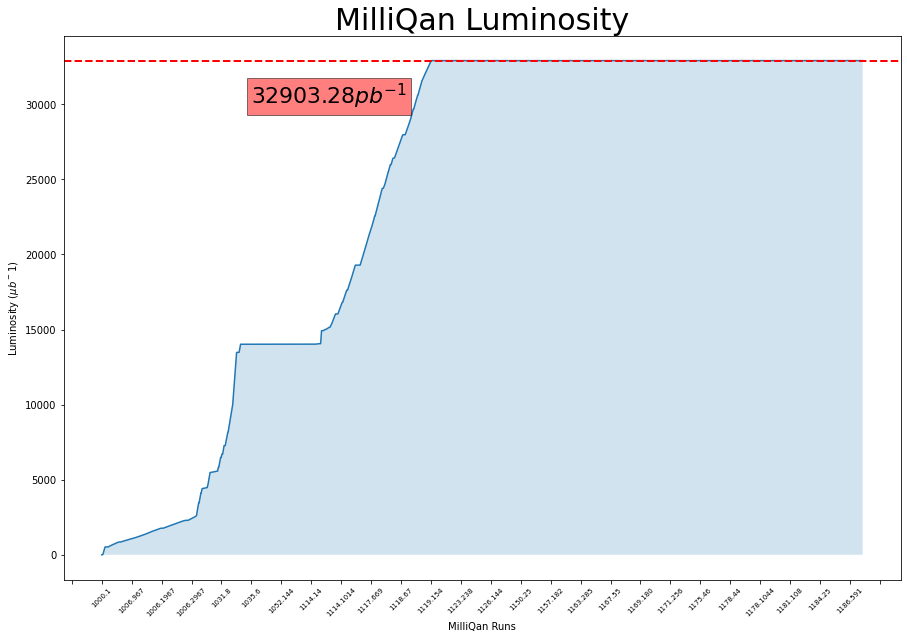

In [24]:
total_lumi = lumis['lumis'].sum()

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

#x_vals = lumis[['run', 'file']].apply(lambda x: str(x.run) + '.' + str(x.file), axis=1)[:5000]
#y_vals = lumis[['lumis', 'run', 'file']].notnull().cumsum()[:5000]
cleaned = lumis[~lumis['lumis'].isnull()]
y_vals = cleaned['lumis'].cumsum()
x_vals = cleaned[['run', 'file']].apply(lambda x: str(x.run) + '.' + str(x.file), axis=1)

ax.plot(x_vals, y_vals)
ax.fill_between(x_vals, y_vals, 0, alpha=0.2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.set_xlabel("MilliQan Runs")
ax.set_ylabel(r"Luminosity $(\mu b^-1)$")
plt.xticks(rotation=45, fontsize=7)
plt.title("MilliQan Luminosity", fontsize=30)
plt. axhline(y=total_lumi, color='r', linestyle='--', linewidth=2)
plt.text(5000, 30000, str(round(total_lumi, 2))+'$pb ^{-1}$', fontsize=22, bbox=dict(facecolor='red', alpha=0.5))

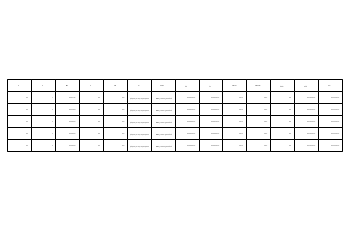

In [8]:
fig, ax = plt.subplots(1, 1)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=lumis[:5].values, colLabels=lumis[5:].columns, loc='center')
plt.show()